# Recommendation system for restaurants
### Based on the [Yelp Dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset).  

## 0. Libraries
First of all, we define all the libraries we need.

In [1]:
from matplotlib.ticker import PercentFormatter as _PercentFormatter
import matplotlib.pyplot as _plt 
import numpy as _np
import pandas as _pd
import joblib as _jl
import glob as _glob
import os as _os
import time as _time
from multiprocessing import Pool as _Pool
from sklearn.preprocessing import LabelBinarizer as _LabelBinarizer, MultiLabelBinarizer as _MultiLabelBinarizer, OrdinalEncoder as _OrdinalEncoder
from sklearn.metrics import confusion_matrix as _confusion_matrix, roc_curve as _roc_curve, classification_report as _classification_report, accuracy_score as _accuracy_score
from sklearn.model_selection import cross_val_score as _cross_val_score
from sklearn.svm import LinearSVC as _LinearSVC

_pd.set_option('display.max_columns', None)

Since we are going to use big datasets, and we'll need to load them more
times, we define a commodity function that deletes all user defined variables,
in order to free some memory.

In [2]:
def _del_all():
    %reset_selective -f [^_]

## 1. Data cleaning
### Based on [Ashish Gandhe's kernel](https://www.kaggle.com/wenqihou828/recommendation-for-yelp-users-itself).

We execute the code in ```recommendation_system_preprocessing.ipynb``` in order to
clean the data and to reduce the size of the dataset, using pickles instead of json and dropping unnecessary columns.

We explore the resulting datasets: 

In [5]:
dataset_list = _glob.glob("../dataset/[!checked]*.pickle")
for d in dataset_list:
    dataset = _pd.read_pickle(d)
    
    f = _os.path.splitext(_os.path.basename(d))[0]
    c = ", ".join(list(dataset.columns))
    s = dataset.shape
    
    print("Dataset '" + f + "':")
    print("\tfeatures:", c)
    print("\tshape:", s)
    print()

Dataset 'all_checkin':
	features: business_id, date
	shape: (57402, 2)

Dataset 'all_review':
	features: review_id, user_id, business_id, stars, useful, funny, cool, text, date
	shape: (4201684, 9)

Dataset 'all_tips':
	features: restaurant_name, tips_date, user_id
	shape: (770878, 3)

Dataset 'all_users':
	features: user_id, user_name, average_stars, yelping_since, review, years_of_elite, fans, useful, cool, funny, friends
	shape: (1148098, 11)

Dataset 'restaurants':
	features: name, business_id, address, cuisine, postal_code, latitude, longitude, review_count, stars, OutdoorSeating, BusinessAcceptsCreditCards, RestaurantsDelivery, RestaurantsReservations, WiFi, Alcohol, categories, city, Monday_Open, Tuesday_Open, Wednesday_Open, Thursday_Open, Friday_Open, Saturday_Open, Sunday_Open, Monday_Close, Tuesday_Close, Wednesday_Close, Thursday_Close, Friday_Close, Saturday_Close, Sunday_Close
	shape: (59371, 31)



In [10]:
_del_all()

## 2. Fake Review Detection
### Based on Zhiwei Zhang's [work](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781) and [code](https://github.com/zzhang83/Yelp_Sentiment_Analysis).

Then, in order to filter out deceptive reviews, that could alter the results
of our analysis, we load the model based on Support Vector Machine
defined in ```Yelp_sentiment_analysis/Scripts/fake_reviews.ipynb```
by [Zhiwei Zhang](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781),
that has the best scores for accuracy, precision, recall and f1-score.

In [2]:
vectorizer = _jl.load('../models/tfidf_vectorizer.joblib')
svc = _jl.load('../models/fake_review_svc_model.joblib')

Now, we can apply this model to our data.

In [4]:
review = _pd.read_pickle("../dataset/all_review.pickle")

review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,I'll be the first to admit that I was not exci...,2013-01-20 13:25:59
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,Tracy dessert had a big name in Hong Kong and ...,2016-05-07 01:21:02
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,This place has gone down hill. Clearly they h...,2010-10-05 19:12:35
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,"Like walking back in time, every Saturday morn...",2011-11-30 02:11:15


In [5]:
texts = list(review["text"])
X = vectorizer.transform(texts)
predictions = svc.predict(X)

In [6]:
print(type(predictions))
print("SVC predictions:", predictions)

<class 'numpy.ndarray'>
SVC predictions: [1 1 1 ... 1 1 1]


Now we repeat the whole process with a different model that allows us to
obtain real weights instead of a binary evaluation. 

In [7]:
cal_svc = _jl.load('../models/fake_review_cal_svc_model.joblib')
cal_predictions = cal_svc.predict_proba(X)


In [8]:
print("Calibrated SVC predictions:\n", cal_predictions)
cal_predictions = _np.array([x[1] for x in cal_predictions])
print("Calibrated SVC predictions for class '1':\n", cal_predictions)

Calibrated SVC predictions:
 [[0.12112422 0.87887578]
 [0.011      0.989     ]
 [0.03538102 0.96461898]
 ...
 [0.36147536 0.63852464]
 [0.00379598 0.99620402]
 [0.00133685 0.99866315]]
Calibrated SVC predictions for class '1':
 [0.87887578 0.989      0.96461898 ... 0.63852464 0.99620402 0.99866315]


In [9]:
print("columns before:\n", review.columns)
checked_review = review.assign(bin_truth_score=predictions, real_truth_score=cal_predictions)
print("columns after:\n", checked_review.columns)

columns before:
 Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
columns after:
 Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'bin_truth_score', 'real_truth_score'],
      dtype='object')


Let's see what we just obtained.

In [10]:
checked_review[['review_id', 'text', 'bin_truth_score', 'real_truth_score']].head()

,review_id,text,bin_truth_score,real_truth_score
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,1,0.878876
5,fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,1,0.989000
6,G7XHMxG0bx9oBJNECG4IFg,Tracy dessert had a big name in Hong Kong and ...,1,0.964619
7,8e9HxxLjjqc9ez5ezzN7iQ,This place has gone down hill. Clearly they h...,1,0.867897
10,kbtscdyz6lvrtGjD1quQTg,"Like walking back in time, every Saturday morn...",1,0.975404


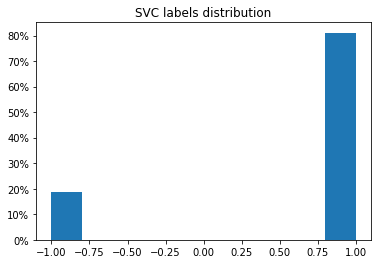

In [11]:
data = checked_review['bin_truth_score']
_plt.hist(data, weights=_np.ones(len(data)) / len(data))
_plt.title("SVC labels distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

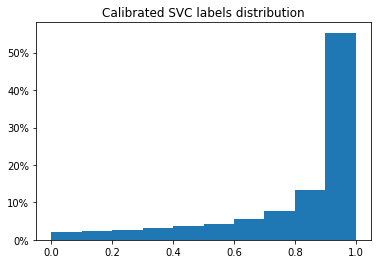

In [12]:
data = checked_review['real_truth_score']
_plt.hist(data, weights=_np.ones(len(data)) / len(data))
_plt.title("Calibrated SVC labels distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

Finally, we can save the new dataset without the ```text``` column,
in order to save space and computation time.  

In [17]:
checked_review.drop(columns=['text'], inplace=True)
checked_review.to_pickle('../dataset/checked_review.pickle')

Check that everything has worked properly. 

In [18]:
final_review = _pd.read_pickle('../dataset/checked_review.pickle')
print(final_review.columns)
final_review.head()

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'date', 'bin_truth_score', 'real_truth_score'],
      dtype='object')


,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,2018-01-09 20:56:38,1,0.878876
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,2013-01-20 13:25:59,1,0.989000
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,2016-05-07 01:21:02,1,0.964619
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,2010-10-05 19:12:35,1,0.867897
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,2011-11-30 02:11:15,1,0.975404


In [ ]:
_del_all()

## 3. Historical features

Following [this paper](https://www.semanticscholar.org/paper/Restaurant-Recommendation-System-Gandhe/093cecc3e53f2ba4c0c466ad3d8294ba64962050),
we add some historical features to our dataset:
1. user-level features:
    <br>1.1. average of the ratings given by a certain user,
    <br>1.2. number of reviews written by a certain user,
2. business-level features:
    <br>2.1. average of the ratings given to a certain restaurant,
    <br>2.2. number of reviews written about a certain restaurant,
3. user-business features:
    <br>3.1. average rating given by a certain user to each category,
    <br>3.2. average of the ratings given by a certain user to the categories of a certain restaurant.

Before proceeding with the computation of the new features, we have to split the dataset in three parts:
1. <i>Test set</i>, from the last day considered in the dataset, to the previous `M` months;
2. <i>Training set</i>, from the day before the beginning of the test set, up to `N` months before;
3. <i>History</i>, the remaining part of the dataset, used to compute historical features.

For the moment, we pick `m=2` and `n=9`, so the test set goes from 10/1/2018 to 11/30/2018,
the training set goes from 1/1/2018 to 9/30/2018, the history contains the remaining data,
from 10/12/2004 to 12/31/2017.

In [7]:
review_all = _pd.read_pickle("../dataset/checked_review.pickle")
review_test = review_all[review_all['date']>=_np.datetime64('2018-10-01')]
review_train = review_all[(review_all['date']>=_np.datetime64('2018-01-01')) & (review_all['date']<_np.datetime64('2018-10-01'))]
review_hist = review_all[review_all['date']<_np.datetime64('2018-01-01')]

review_test.to_pickle('../dataset/m2_n9/review_test.pickle')
review_train.to_pickle('../dataset/m2_n9/review_train.pickle')
review_hist.to_pickle('../dataset/m2_n9/review_hist.pickle')

In [13]:
tips_all = _pd.read_pickle("../dataset/all_tips.pickle")
tips_test = tips_all[tips_all['tips_date']>=_np.datetime64('2018-10-01')]
tips_train = tips_all[(tips_all['tips_date']>=_np.datetime64('2018-01-01')) & (tips_all['tips_date']<_np.datetime64('2018-10-01'))]
tips_hist = tips_all[tips_all['tips_date']<_np.datetime64('2018-01-01')]

tips_test.to_pickle('../dataset/m2_n9/tips_test.pickle')
tips_train.to_pickle('../dataset/m2_n9/tips_train.pickle')
tips_hist.to_pickle('../dataset/m2_n9/tips_hist.pickle')

In [18]:
_del_all()

### User-level features

In [3]:
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
users = _pd.read_pickle("../dataset/all_users.pickle")

In [8]:
avg_stars = review_hist['stars'].mean()

users = users.assign(average_stars=avg_stars)
users = users.assign(num_reviews=0)
users = users.assign(average_stars_bin=avg_stars)
users = users.assign(num_reviews_bin=0)
users = users.assign(average_stars_real=avg_stars)
users = users.assign(num_reviews_real=0)
users = users.set_index('user_id')
users.head()

,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
user_id,,,,,,,,,,,,,,,
l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.703313,2013-10-08,95,3,5,84,25,17,2374,0,3.703313,0,3.703313,0
4XChL029mKr5hydo79Ljxg,Jenna,3.703313,2013-02-21,33,0,4,48,16,22,27646,0,3.703313,0,3.703313,0
bc8C_eETBWL0olvFSJJd0w,David,3.703313,2013-10-04,16,0,0,28,10,8,358,0,3.703313,0,3.703313,0
dD0gZpBctWGdWo9WlGuhlA,Angela,3.703313,2014-05-22,17,0,5,30,14,4,12598,0,3.703313,0,3.703313,0
MM4RJAeH6yuaN8oZDSt0RA,Nancy,3.703313,2013-10-23,361,4,39,1114,665,279,5542,0,3.703313,0,3.703313,0


In [3]:
def _f(grouped):
    d = {}
    
    d['num'] = grouped['stars'].size
    d['stars'] = grouped['stars'].mean()
    
    non_fake = _np.ma.masked_where(grouped['bin_truth_score']<0, grouped['stars']).compressed()
    d['num_bin'] = non_fake.size
    d['stars_bin'] = non_fake.mean()
    
    d['num_real'] = grouped['real_truth_score'].sum()
    d['stars_real'] = _np.average(grouped['stars'], weights=grouped['real_truth_score'])
    
    return _pd.Series(d, index=['num', 'stars', 'num_bin', 'stars_bin', 'num_real', 'stars_real'])

In [ ]:
grouped_reviews = review_hist.groupby('user_id').apply(_f)
grouped_reviews.head()

In [18]:
import random
import statistics

current_milli_time = lambda: int(round(_time.time() * 1000))

def get_time(df):
    us_id = random.choice(grouped_reviews.index)
    x = random.randrange(1000)
    t = current_milli_time()
    df.loc[us_id, ["test"]] = x
    t0 = current_milli_time()
    return t0-t

def get_time_mul(df):
    us_id = random.choice(grouped_reviews.index)
    x = random.randrange(1000)
    y = random.randrange(1000)
    z = random.randrange(1000)
    t = current_milli_time()
    df.loc[us_id, ["test", "ciao", "prova"]] = [x, y, z]
    t0 = current_milli_time()
    return t0-t

def test():
    df = users.copy()
    df['test'] = -1
    times = []
    for i in range(1000):
         times += [get_time(df)]
    avg_time = statistics.mean(times)
    del df
    return avg_time

def test_mul():
    df = users.copy()
    df['test'] = -1
    df['ciao'] = -1
    df['prova'] = -1
    times = []
    for i in range(1000):
         times += [get_time(df)]
    avg_time = statistics.mean(times)
    del df
    return avg_time

def tot_time(ops, x, k):
    time_millis = ops * k * x
    hours = time_millis/1000/60/60
    return hours

tot = len(grouped_reviews)
x = test()
print("hours:", tot_time(tot, x, 6))
x = test_mul()
print("hours mul:", tot_time(tot, x, 1))

hours: 53.065662455
hours mul: 8.774814544166667


In [9]:
count = 1
tot = len(grouped_reviews)
print("tot:", tot)

for index, row in grouped_reviews.iterrows():
    uid = index
    num = row['num']
    stars = row['stars']
    num_bin = row['num_bin']
    stars_bin = row['stars_bin']
    num_real = row['num_real']
    stars_real = row['stars_real']
    
    cols = ["num_reviews", "average_stars", "num_reviews_bin",
            "average_stars_bin", "num_reviews_real", "average_stars_real"]
    vals = [num, stars, num_bin, stars_bin, num_real, stars_real]
    users.loc[uid, cols] = vals
    
    count += 1
    if count % 1000 == 0:
        percent = (count/tot)*100
        print("row {}/{} - {}%".format(count, tot, percent))

tot: 954447
row 1000/954447 - 0.10477271131870078%
row 2000/954447 - 0.20954542263740156%
row 3000/954447 - 0.31431813395610236%
row 4000/954447 - 0.4190908452748031%
row 5000/954447 - 0.5238635565935038%
row 6000/954447 - 0.6286362679122047%
row 7000/954447 - 0.7334089792309054%
row 8000/954447 - 0.8381816905496062%
row 9000/954447 - 0.942954401868307%
row 10000/954447 - 1.0477271131870076%
row 11000/954447 - 1.1524998245057085%
row 12000/954447 - 1.2572725358244095%
row 13000/954447 - 1.3620452471431101%
row 14000/954447 - 1.4668179584618108%
row 15000/954447 - 1.5715906697805118%
row 16000/954447 - 1.6763633810992125%
row 17000/954447 - 1.7811360924179132%
row 18000/954447 - 1.885908803736614%
row 19000/954447 - 1.9906815150553148%
row 20000/954447 - 2.0954542263740152%
row 21000/954447 - 2.2002269376927166%
row 22000/954447 - 2.304999649011417%
row 23000/954447 - 2.409772360330118%
row 24000/954447 - 2.514545071648819%
row 25000/954447 - 2.6193177829675194%
row 26000/954447 - 2.724

In [10]:
users = users.reset_index()
users.to_pickle('../dataset/m2_n9/users.pickle')
_del_all()

### Business-level features

In [4]:
restaurants = _pd.read_pickle("../dataset/restaurants.pickle")
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
avg_stars = review_hist['stars'].mean()

In [5]:
restaurants = restaurants.assign(average_stars=avg_stars)
restaurants = restaurants.assign(num_reviews=0)
restaurants = restaurants.assign(average_stars_bin=avg_stars)
restaurants = restaurants.assign(num_reviews_bin=0)
restaurants = restaurants.assign(average_stars_real=avg_stars)
restaurants = restaurants.assign(num_reviews_real=0)
restaurants = restaurants.set_index('business_id')
restaurants.head()

,name,address,cuisine,postal_code,latitude,longitude,review_count,stars,OutdoorSeating,BusinessAcceptsCreditCards,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
business_id,,,,,,,,,,,,,,,,,,,,,
QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Chinese,L5R 3E7,43.605499,-79.652289,128,2.5,False,NaN,...,00:00:00,01:00:00,01:00:00,00:00:00,3.703313,0,3.703313,0,3.703313,0
gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Japanese,28210,35.092564,-80.859132,170,4.0,False,True,...,21:30:00,22:00:00,22:00:00,21:00:00,3.703313,0,3.703313,0,3.703313,0
1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Mexican,85016,33.495194,-112.028588,18,3.0,False,True,...,01:00:00,01:00:00,01:00:00,00:00:00,3.703313,0,3.703313,0,3.703313,0
fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Italian,44060,41.708520,-81.359556,16,4.0,False,True,...,00:00:00,01:00:00,01:00:00,00:00:00,3.703313,0,3.703313,0,3.703313,0
PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Italian,89119,36.100016,-115.128529,40,4.0,False,True,...,NaT,NaT,NaT,NaT,3.703313,0,3.703313,0,3.703313,0


In [6]:
grouped_reviews = review_hist.groupby('business_id').apply(_f)
grouped_reviews.head()

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,num,stars,num_bin,stars_bin,num_real,stars_real
business_id,,,,,,
--1UhMGODdWsrMastO9DZw,22.0,4.227273,14.0,4.214286,16.978214,4.267477
--6MefnULPED_I942VcFNA,38.0,3.157895,32.0,3.218750,33.948759,3.218815
--9e1ONYQuAa-CB_Rrw7Tw,1504.0,4.107048,1216.0,4.088816,1205.738732,4.092415
--DaPTJW3-tB1vP-PfdTEg,40.0,3.650000,33.0,3.575758,34.780500,3.642790
--FBCX-N37CMYDfs790Bnw,122.0,3.737705,90.0,3.611111,93.369750,3.646290


In [7]:
count = 1
tot = len(grouped_reviews)
print("tot:", tot)

for index, row in grouped_reviews.iterrows():
    uid = index
    num = row['num']
    stars = row['stars']
    num_bin = row['num_bin']
    stars_bin = row['stars_bin']
    num_real = row['num_real']
    stars_real = row['stars_real']
    
    cols = ["num_reviews", "average_stars", "num_reviews_bin",
            "average_stars_bin", "num_reviews_real", "average_stars_real"]
    vals = [num, stars, num_bin, stars_bin, num_real, stars_real]
    restaurants.loc[uid, cols] = vals
    
    count += 1
    if count % 1000 == 0:
        percent = (count/tot)*100
        print("row {}/{} - {}%".format(count, tot, percent))

tot: 56850
row 1000/56850 - 1.759014951627089%
row 2000/56850 - 3.518029903254178%
row 3000/56850 - 5.277044854881266%
row 4000/56850 - 7.036059806508356%
row 5000/56850 - 8.795074758135444%
row 6000/56850 - 10.554089709762533%
row 7000/56850 - 12.313104661389621%
row 8000/56850 - 14.072119613016712%
row 9000/56850 - 15.8311345646438%
row 10000/56850 - 17.590149516270888%
row 11000/56850 - 19.349164467897978%
row 12000/56850 - 21.108179419525065%
row 13000/56850 - 22.867194371152156%
row 14000/56850 - 24.626209322779243%
row 15000/56850 - 26.385224274406333%
row 16000/56850 - 28.144239226033424%
row 17000/56850 - 29.90325417766051%
row 18000/56850 - 31.6622691292876%
row 19000/56850 - 33.42128408091469%
row 20000/56850 - 35.180299032541775%
row 21000/56850 - 36.93931398416886%
row 22000/56850 - 38.698328935795956%
row 23000/56850 - 40.45734388742304%
row 24000/56850 - 42.21635883905013%
row 25000/56850 - 43.97537379067722%
row 26000/56850 - 45.73438874230431%
row 27000/56850 - 47.49340

In [8]:
restaurants = restaurants.reset_index()
restaurants.to_pickle('../dataset/m2_n9/restaurants.pickle')
_del_all()


### User - Business level features

#### 3.1. average rating given by a certain user to each category

In [2]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants.head()

,business_id,name,address,cuisine,postal_code,latitude,longitude,review_count,stars,OutdoorSeating,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Chinese,L5R 3E7,43.605499,-79.652289,128,2.5,False,...,00:00:00,01:00:00,01:00:00,00:00:00,2.726496,117.0,2.718750,96.0,2.730197,95.873087
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Japanese,28210,35.092564,-80.859132,170,4.0,False,...,21:30:00,22:00:00,22:00:00,21:00:00,4.063291,158.0,4.094203,138.0,4.067541,139.112078
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Mexican,85016,33.495194,-112.028588,18,3.0,False,...,01:00:00,01:00:00,01:00:00,00:00:00,3.125000,16.0,2.769231,13.0,2.847327,12.604125
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Italian,44060,41.708520,-81.359556,16,4.0,False,...,00:00:00,01:00:00,01:00:00,00:00:00,4.230769,13.0,4.166667,12.0,4.142021,10.965903
4,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Italian,89119,36.100016,-115.128529,40,4.0,False,...,NaT,NaT,NaT,NaT,4.097561,41.0,4.212121,33.0,4.167159,33.655622


In [5]:
restaurants.columns

Index(['business_id', 'name', 'address', 'cuisine', 'postal_code', 'latitude',
       'longitude', 'review_count', 'stars', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'RestaurantsDelivery',
       'RestaurantsReservations', 'WiFi', 'Alcohol', 'categories', 'city',
       'Monday_Open', 'Tuesday_Open', 'Wednesday_Open', 'Thursday_Open',
       'Friday_Open', 'Saturday_Open', 'Sunday_Open', 'Monday_Close',
       'Tuesday_Close', 'Wednesday_Close', 'Thursday_Close', 'Friday_Close',
       'Saturday_Close', 'Sunday_Close', 'average_stars', 'num_reviews',
       'average_stars_bin', 'num_reviews_bin', 'average_stars_real',
       'num_reviews_real'],
      dtype='object')

In [3]:
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
review_hist.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,2013-01-20 13:25:59,1,0.989000
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,2016-05-07 01:21:02,1,0.964619
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,2010-10-05 19:12:35,1,0.867897
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,2011-11-30 02:11:15,1,0.975404
11,-I5umRTkhw15RqpKMl_o1Q,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1,0,1,0,2017-12-15 23:27:08,1,0.972826


In [4]:
joined_reviews = review_hist.join(restaurants.set_index('business_id'), on = 'business_id', lsuffix='_review', rsuffix='_rest')
joined_reviews.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,real_truth_score,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,2013-01-20 13:25:59,1,0.989000,...,22:00:00,23:00:00,23:00:00,NaT,3.642276,123.0,3.594059,101.0,3.596369,99.505441
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,2016-05-07 01:21:02,1,0.964619,...,00:00:00,02:00:00,02:00:00,00:00:00,3.292453,106.0,3.320000,100.0,3.289493,94.480786
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,2010-10-05 19:12:35,1,0.867897,...,22:00:00,23:00:00,23:00:00,23:00:00,2.655172,29.0,2.875000,24.0,2.727490,23.413530
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,2011-11-30 02:11:15,1,0.975404,...,23:00:00,00:00:00,00:00:00,23:00:00,4.491259,1144.0,4.499535,1075.0,4.502904,1031.313358
11,-I5umRTkhw15RqpKMl_o1Q,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1,0,1,0,2017-12-15 23:27:08,1,0.972826,...,00:00:00,02:00:00,02:00:00,00:00:00,3.666667,12.0,3.833333,6.0,3.650460,7.482296


In [8]:
categories = ', '.join(list(restaurants['categories'].unique()))
categories = categories.split(', ')
print(len(categories))

cat = []
for h in categories:
    if h not in cat:
        cat.append(h)
        
print(len(cat))

cuisines = ', '.join(list(restaurants['cuisine'].unique()))
cuisines = cuisines.split(', ')
print(len(cuisines))

_cuisines_unique = []
for cuisine in cuisines:
    if not cuisine in _cuisines_unique:
        _cuisines_unique.append(cuisine)
        
print("Number of cuisines: {0}".format(len(_cuisines_unique)))
print(_cuisines_unique)

173884
761
249
Number of cuisines: 10
['Chinese', 'Japanese', 'Mexican', 'Italian', 'Others', 'American', 'Korean', 'Mediterranean', 'Thai', 'Asian Fusion']


In [5]:
joined_reviews.to_pickle('../dataset/m2_n9/join_restaurants_reviewhist.pickle')

In [ ]:
_del_all()

Checkpoint

In [ ]:
joined_reviews =  _pd.read_pickle('../dataset/m2_n9/join_restaurants_reviewhist.pickle')
joined_reviews.head()

,index,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,2013-01-20 13:25:59,1,...,22:00:00,23:00:00,23:00:00,NaT,3.642276,123.0,3.594059,101.0,3.596369,99.505441
1,6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,2016-05-07 01:21:02,1,...,00:00:00,02:00:00,02:00:00,00:00:00,3.292453,106.0,3.320000,100.0,3.289493,94.480786
2,7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,2010-10-05 19:12:35,1,...,22:00:00,23:00:00,23:00:00,23:00:00,2.655172,29.0,2.875000,24.0,2.727490,23.413530
3,10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,2011-11-30 02:11:15,1,...,23:00:00,00:00:00,00:00:00,23:00:00,4.491259,1144.0,4.499535,1075.0,4.502904,1031.313358
4,11,-I5umRTkhw15RqpKMl_o1Q,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1,0,1,0,2017-12-15 23:27:08,1,...,00:00:00,02:00:00,02:00:00,00:00:00,3.666667,12.0,3.833333,6.0,3.650460,7.482296


In [ ]:
# joined_reviews = joined_reviews.reset_index()
joined_reviews = joined_reviews[['review_id', 'user_id', 'business_id', 'bin_truth_score', 'real_truth_score', 'cuisine', 'stars_review']]
joined_reviews.head()

,review_id,user_id,business_id,bin_truth_score,real_truth_score,cuisine,stars_review
0,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,1,0.989000,Italian,4
1,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,1,0.964619,Chinese,3
2,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,0.867897,American,1
3,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,1,0.975404,Others,4
4,-I5umRTkhw15RqpKMl_o1Q,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1,0.972826,American,1


In [ ]:
#cuisines_unique = ['Chinese', 'Japanese', 'Mexican', 'Italian', 'Others', 'American', 'Korean', 'Mediterranean', 'Thai', 'Asian Fusion']

In [ ]:
def each_cuisine_ratings(grouped):
    d = {}
    index = []
    for cuisine in _cuisines_unique:
        cuisine_av = cuisine + "_av"
        cuisine_records = _np.ma.masked_where(~grouped['cuisine'].str.contains(cuisine), grouped['stars_review']).compressed()
        d[cuisine_av] = cuisine_records.mean()
        index.append(cuisine_av)
    # print("cuisine_av done")
        
    for cuisine in _cuisines_unique:
        cuisine_av_bin = cuisine + "_av_bin"
        #non_fake = _np.ma.masked_where(grouped['bin_truth_score'] < 0, grouped).compressed()
        non_fake = grouped[grouped['bin_truth_score'] > 0]
        cuisine_records = _np.ma.masked_where(~non_fake['cuisine'].str.contains(cuisine), non_fake['stars_review']).compressed()
        d[cuisine_av_bin] = cuisine_records.mean()
        index.append(cuisine_av_bin)
    # print("cuisine_av_bin done")
    
    for cuisine in _cuisines_unique:
        cuisine_av_real = cuisine + "_av_real"
        cuisine_records = _np.ma.masked_where(~grouped['cuisine'].str.contains(cuisine), grouped['stars_review']).compressed()
        cuisine_truth_score = _np.ma.masked_where(~grouped['cuisine'].str.contains(cuisine), grouped['real_truth_score']).compressed()
        d[cuisine_av_real] = _np.ma.average(cuisine_records, weights = cuisine_truth_score)
        index.append(cuisine_av_real)
    # print("cuisine_av_real done")
    
    return _pd.Series(d, index = index)
    

In [ ]:
grouped_reviews = joined_reviews.groupby('user_id').apply(each_cuisine_ratings)

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\ma\extras.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


In [ ]:
grouped_reviews.head()

,Chinese_av,Japanese_av,Mexican_av,Italian_av,Others_av,American_av,Korean_av,Mediterranean_av,Thai_av,Asian Fusion_av,...,Chinese_av_real,Japanese_av_real,Mexican_av_real,Italian_av_real,Others_av_real,American_av_real,Korean_av_real,Mediterranean_av_real,Thai_av_real,Asian Fusion_av_real
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,NaN,2.333333,3.666667,3.166667,4.352941,3.9375,4.0,NaN,3.25,3.5,...,NaN,2.035809,3.720609,3.226154,4.524134,3.963953,4.0,NaN,3.134858,3.443446
---PLwSf5gKdIoVnyRHgBA,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN
---cu1hq55BP9DWVXXKHZg,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
---udAKDsn0yQXmzbWQNSw,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,4.00,NaN,...,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,4.000000,NaN
--0RtXvcOIE4XbErYca6Rw,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN


Checkpoint 2

In [3]:
users = _pd.read_pickle('../dataset/m2_n9/users.pickle')
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,2.0,3.000000,2.0,3.017247,1.957334
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,12.0,3.777778,9.0,3.626019,9.280533
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,13.0,3.500000,12.0,3.326528,10.350275
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,1.0,NaN,0.0,5.000000,0.329341
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,5.0,4.400000,5.0,4.378799,4.720870


In [4]:
users = users.assign(av_rat_chinese_cuisine = _np.nan, av_rat_japanese_cuisine = _np.nan, av_rat_mexican_cuisine = _np.nan, 
                     av_rat_italian_cuisine = _np.nan, av_rat_others_cuisine = _np.nan, av_rat_american_cuisine = _np.nan, 
                     av_rat_korean_cuisine = _np.nan, av_rat_mediterranean_cuisine = _np.nan, av_rat_thai_cuisine = _np.nan, 
                     av_rat_asianfusion_cuisine = _np.nan)

users = users.assign(av_rat_chinese_cuisine_bin = _np.nan, av_rat_japanese_cuisine_bin = _np.nan, av_rat_mexican_cuisine_bin = _np.nan, 
                     av_rat_italian_cuisine_bin = _np.nan, av_rat_others_cuisine_bin = _np.nan, av_rat_american_cuisine_bin = _np.nan, 
                     av_rat_korean_cuisine_bin = _np.nan, av_rat_mediterranean_cuisine_bin = _np.nan, av_rat_thai_cuisine_bin = _np.nan, 
                     av_rat_asianfusion_cuisine_bin = _np.nan)

users = users.assign(av_rat_chinese_cuisine_real = _np.nan, av_rat_japanese_cuisine_real = _np.nan, av_rat_mexican_cuisine_real = _np.nan, 
                     av_rat_italian_cuisine_real = _np.nan, av_rat_others_cuisine_real = _np.nan, av_rat_american_cuisine_real = _np.nan, 
                     av_rat_korean_cuisine_real = _np.nan, av_rat_mediterranean_cuisine_real = _np.nan, av_rat_thai_cuisine_real = _np.nan, 
                     av_rat_asianfusion_cuisine_real = _np.nan)

users = users.set_index('user_id')

In [5]:
users.head()

,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
user_id,,,,,,,,,,,,,,,,,,,,,
l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
grouped_reviews = _pd.read_pickle('../dataset/m2_n9/grouped_reviews.pickle')
grouped_reviews.head()

,Chinese_av,Japanese_av,Mexican_av,Italian_av,Others_av,American_av,Korean_av,Mediterranean_av,Thai_av,Asian Fusion_av,...,Chinese_av_real,Japanese_av_real,Mexican_av_real,Italian_av_real,Others_av_real,American_av_real,Korean_av_real,Mediterranean_av_real,Thai_av_real,Asian Fusion_av_real
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,NaN,2.333333,3.666667,3.166667,4.352941,3.9375,4.0,NaN,3.25,3.5,...,NaN,2.035809,3.720609,3.226154,4.524134,3.963953,4.0,NaN,3.134858,3.443446
---PLwSf5gKdIoVnyRHgBA,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN
---cu1hq55BP9DWVXXKHZg,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
---udAKDsn0yQXmzbWQNSw,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,4.00,NaN,...,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,4.000000,NaN
--0RtXvcOIE4XbErYca6Rw,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN


In [8]:
# split grouped_reviews and users datasets into n_cores parts, where n_cores is the number of available processors
n_cores = _os.cpu_count()

df_out = _np.array_split(users, n_cores)   # list of input dataframes (from grouped_reviews)

df_out_names = []   # list of paths of output dataframes (from users)
df_in = []
for i, df in enumerate(df_out):
    name = "../dataset/m2_n9/tmp/df_out_" + str(i) + ".pickle"
    df_out_names += [name]
    
    df_tmp = grouped_reviews.loc[df.index]
    df_in += [df_tmp]

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


In [9]:
from multiproc_utils import user_business_features

if __name__ ==  '__main__':
    with _Pool(processes=n_cores) as p:
        p.map(user_business_features, zip(df_in, df_out, df_out_names))

In [10]:
users_chunks = []

# add chunks produced by subprocesses
for name in df_out_names:
    df_out_i = _pd.read_pickle(name)
    users_chunks += [df_out_i]
    _os.remove(name)

users = _pd.concat(users_chunks)
users.head()

,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
user_id,,,,,,,,,,,,,,,,,,,,,
l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,...,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,...,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,...,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,...,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [11]:
users = users.reset_index()
users.to_pickle('../dataset/m2_n9/users_2.pickle')

In [12]:
users.shape

(1148098, 46)

In [13]:
users_pre = _pd.read_pickle("../dataset/m2_n9/users.pickle")
users_pre.shape

(1148098, 16)

In [4]:
len(grouped_reviews)

954447

In [7]:
print("expected diff:", users.shape[0]-len(grouped_reviews))

expected diff: 193651


In [8]:
users_tmp = users[['av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine',
           
           'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
           'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
           'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
           'av_rat_asianfusion_cuisine_bin',
           
           'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
           'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
           'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
           'av_rat_asianfusion_cuisine_real']]

count_na = 0
for i, r in users_tmp.iterrows():
        if r.isna().all():
            count_na += 1

print("actual diff:", count_na)

actual diff: 193651


In [71]:
_del_all()

#### 3.2. average of the ratings given by a certain user to the categories of a certain restaurant.

##### 3.2.1 Test set

In [26]:
review_test = _pd.read_pickle('../dataset/m2_n9/review_test.pickle')
review_test = review_test.sort_values(by=['review_id'])
review_test = review_test.reset_index(drop = True)
review_test.shape

(91434, 10)

In [27]:
review_test.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471


In [28]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants = restaurants[['cuisine', 'business_id']]
restaurants.head()

,cuisine,business_id
0,Chinese,QXAEGFB4oINsVuTFxEYKFQ
1,Japanese,gnKjwL_1w79qoiV3IC_xQQ
2,Mexican,1Dfx3zM-rW4n-31KeC8sJg
3,Italian,fweCYi8FmbJXHCqLnwuk8w
4,Italian,PZ-LZzSlhSe9utkQYU8pFg


In [29]:
review_test_rest = review_test.join(restaurants.set_index('business_id'), on = 'business_id')
review_test_rest.to_pickle('../dataset/m2_n9/review_test_cuisine.pickle')
review_test_rest.shape

(91434, 11)

In [30]:
review_test_rest.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,American
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,Others
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,Mediterranean
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,Others
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,Italian


In [31]:
del restaurants

users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,...,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,...,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,...,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,...,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [32]:
users = users[['user_id', 'av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine',
           
           'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
           'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
           'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
           'av_rat_asianfusion_cuisine_bin',
           
           'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
           'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
           'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
           'av_rat_asianfusion_cuisine_real']]

users.head()

,user_id,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,NaN,NaN,NaN,NaN,4.0,3.333333,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,3.5,NaN,2.0,NaN,5.0,3.000000,NaN,3.0,3.666667,...,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,...,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [33]:
test_join = review_test_rest.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_test_revirew', rsuffix = '_users')
test_join.shape

(91434, 41)

In [34]:
test_join.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,...,NaN,4.000000,NaN,4.508384,3.446572,3.969038,NaN,NaN,NaN,4.102936
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,...,3.756843,3.726028,4.287215,3.525072,3.610109,3.170261,2.0,4.355007,3.664197,3.021022
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,...,NaN,NaN,1.000000,NaN,5.000000,5.000000,NaN,5.000000,NaN,NaN
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
test_join.to_pickle('../dataset/m2_n9/join_test_users_review.pickle')
del users, review_test_rest

In [36]:
def _restaturants_users_cuisine_ratings(grouped):
    cuisines = str(grouped['cuisine']).split(", ")
    
    d = {'review_id' : grouped['review_id'],'cuisine_av_hist' : 0, 'cuisine_av_hist_bin' : 0, 'cuisine_av_hist_real': 0}
    index = ['review_id', 'cuisine_av_hist', 'cuisine_av_hist_bin', 'cuisine_av_hist_real']
   
    values = []
    for cuisine in cuisines:
        cui = cuisine.lower().replace(" ", "")
        name = "av_rat_{0}_cuisine".format(cui)
        values.append(grouped[name])
    d['cuisine_av_hist'] = _np.average(values)
    
    values = []
    for cuisine in cuisines:
        cui = cuisine.lower().replace(" ", "")
        name = "av_rat_{0}_cuisine_bin".format(cui)
        values.append(grouped[name])
    d['cuisine_av_hist_bin'] = _np.average(values)
    
    values = []
    for cuisine in cuisines:
        cui = cuisine.lower().replace(" ", "")
        name = "av_rat_{0}_cuisine_real".format(cui)
        values.append(grouped[name])
    d['cuisine_av_hist_real'] = _np.average(values)
    
    return _pd.Series(d, index = index)

In [37]:
applied_test = test_join.apply(_restaturants_users_cuisine_ratings, axis = 1)
applied_test.shape

(91434, 4)

In [38]:
applied_test = applied_test.sort_values(by=['review_id'])
applied_test = applied_test.reset_index(drop = True)
applied_test.head()

,review_id,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real
0,---j05qHS2X7FkXjjMKKtA,4.000000,4.285714,3.969038
1,--4GjusuUCMh24c_oh_cEg,3.604167,3.607143,3.610109
2,--4RpVT5wHJ9AfnZkIC3tw,5.000000,NaN,5.000000
3,--4vJzoC0m5h-yodXv-qCw,NaN,NaN,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,NaN,NaN,NaN


In [39]:
applied_test.to_pickle('../dataset/m2_n9/applied_test_users_review.pickle')

In [40]:
review_test.shape

(91434, 10)

In [41]:
review_test.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471


In [42]:
review_test = review_test.assign(cuisine_av_hist = applied_test['cuisine_av_hist'],
                                 cuisine_av_hist_bin = applied_test['cuisine_av_hist_bin'],
                                 cuisine_av_hist_real = applied_test['cuisine_av_hist_real'])
review_test.shape

(91434, 13)

In [43]:
review_test.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,4.000000,4.285714,3.969038
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,3.604167,3.607143,3.610109
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,5.000000,NaN,5.000000
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,NaN,NaN,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,NaN,NaN,NaN


In [46]:
test_set = review_test
test_set.to_pickle('../dataset/m2_n9/review_test_cuisine_final.pickle')
_del_all()

##### 3.2.2 Training set

In [47]:
review_train = _pd.read_pickle('../dataset/m2_n9/review_train.pickle')
review_train = review_train.sort_values(by=['review_id'])
review_train = review_train.reset_index(drop = True)
review_train.shape

(620945, 10)

In [48]:
review_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956


In [49]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants = restaurants[['cuisine', 'business_id']]
restaurants.head()

,cuisine,business_id
0,Chinese,QXAEGFB4oINsVuTFxEYKFQ
1,Japanese,gnKjwL_1w79qoiV3IC_xQQ
2,Mexican,1Dfx3zM-rW4n-31KeC8sJg
3,Italian,fweCYi8FmbJXHCqLnwuk8w
4,Italian,PZ-LZzSlhSe9utkQYU8pFg


In [50]:
review_train_rest = review_train.join(restaurants.set_index('business_id'), on = 'business_id')
review_train_rest.to_pickle('../dataset/m2_n9/review_train_cuisine.pickle')
review_train_rest.shape

(620945, 11)

In [51]:
review_train_rest.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,"Italian, Mediterranean"
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,Others
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,American
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,Others
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,American


In [52]:
del restaurants

users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,...,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,...,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,...,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,...,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [53]:
users = users[['user_id', 'av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine',
           
           'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
           'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
           'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
           'av_rat_asianfusion_cuisine_bin',
           
           'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
           'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
           'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
           'av_rat_asianfusion_cuisine_real']]

users.head()

,user_id,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,NaN,NaN,NaN,NaN,4.0,3.333333,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,3.5,NaN,2.0,NaN,5.0,3.000000,NaN,3.0,3.666667,...,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,...,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [54]:
train_join = review_train_rest.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_train_revirew', rsuffix = '_users')
train_join.shape

(620945, 41)

In [55]:
train_join.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,...,NaN,NaN,NaN,NaN,3.022921,NaN,NaN,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,...,3.821347,2.726907,4.0,3.303025,3.039444,3.145065,2.847918,3.387395,2.572254,2.752899
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,...,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,...,NaN,NaN,4.0,4.507847,5.000000,2.748879,NaN,NaN,NaN,NaN


In [56]:
train_join.to_pickle('../dataset/m2_n9/join_train_users_review.pickle')
del users, review_train_rest

In [57]:
applied_train = train_join.apply(_restaturants_users_cuisine_ratings, axis = 1)
applied_train.shape

(620945, 4)

In [58]:
applied_train = applied_train.sort_values(by=['review_id'])
applied_train = applied_train.reset_index(drop = True)
applied_train.head()

,review_id,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real
0,---HLAnHbuLi7vd5TL6uYg,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,3.013889,3.014925,3.039444
2,---sPYSgArT4Sd5v1nDVMQ,NaN,NaN,NaN
3,--0SzSMXVUoAXfackNoB4g,1.000000,1.000000,1.000000
4,--1JMhPk6K9fZo4FOp_yMw,2.750000,2.666667,2.748879


In [59]:
applied_train.to_pickle('../dataset/m2_n9/applied_train_users_review.pickle')

In [60]:
review_train.shape

(620945, 10)

In [61]:
review_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956


In [62]:
review_train = review_train.assign(cuisine_av_hist = applied_train['cuisine_av_hist'],
                                   cuisine_av_hist_bin = applied_train['cuisine_av_hist_bin'],
                                   cuisine_av_hist_real = applied_train['cuisine_av_hist_real'])
review_train.shape

(620945, 13)

In [63]:
review_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,3.013889,3.014925,3.039444
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,NaN,NaN,NaN
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,1.000000,1.000000,1.000000
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,2.750000,2.666667,2.748879


In [64]:
train_set = review_train
train_set.to_pickle('../dataset/m2_n9/review_train_cuisine_final.pickle')
_del_all()

## 4 Some more preprocessing

 - We don't need the dataset <i>checkin</i>, and from the dataset <i>tips</i>
   we take only the feature "compliments"
 - The train set is a join of all the data needed for training
 - The test set is a join of all the data needed for training and performance evaluation (labels included)
 - The label is a feature 'likes' that is 1 if that user will like that
   restaurant (4 or 5 stars) or 0 if he/she won't like that restaurant (1, 2 or 3 stars)

#### 4.1 Training set

In [128]:
review_train = _pd.read_pickle('../dataset/m2_n9/review_train_cuisine_final.pickle')
review_train = review_train.assign(likes = _np.nan)
review_train['likes'] = _np.where(review_train['stars'].isin([4, 5]), 1, 0)
review_train.head(10)

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,likes
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,NaN,NaN,NaN,1
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,3.013889,3.014925,3.039444,1
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,NaN,NaN,NaN,0
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,1.000000,1.000000,1.000000,1
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,2.750000,2.666667,2.748879,0
5,--23TchR_Yc84EtfTkjvlg,w9URAIc40f_vYRuAGZ_9qQ,m9Cme6bUPuZFtqhN1AgmdQ,4,2,1,1,2018-05-23 20:34:46,1,0.903279,NaN,NaN,NaN,1
6,--29SBl8OUdsRP0aSm-Sxw,P2Q7PgJamWesMxRxI0av_Q,TW53EB3Xw-uWnN3XS8qulQ,1,0,0,0,2018-07-30 15:45:24,1,0.937554,NaN,NaN,NaN,0
7,--2JNWfwcbPf_LMWQhTlvw,vbmdBC5KLHCdvbiU6s4DJw,szhJLmdLDVFTevm8fu0T4A,5,0,0,0,2018-04-21 22:10:13,1,0.931162,5.000000,5.000000,5.000000,1
8,--2UJ2rdoEvNsqSHQm5C2g,XN3nlWBW6kZQYJsQTQj-8g,_RiwESa2w64ls6y_5tE4CA,4,0,0,0,2018-07-25 00:21:40,1,0.971406,5.000000,5.000000,5.000000,1
9,--2mkkp6fjhRNKvouP53Ug,1WV2BAfZPP1Bv_1Y7_8Jmg,Y1Y5aSg5YUFHkpqUnkydig,1,1,0,1,2018-05-26 03:47:35,1,0.892099,3.000000,2.428571,2.770630,0


In [129]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants.head()

,business_id,name,address,cuisine,postal_code,latitude,longitude,review_count,stars,OutdoorSeating,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Chinese,L5R 3E7,43.605499,-79.652289,128,2.5,False,...,00:00:00,01:00:00,01:00:00,00:00:00,2.726496,117.0,2.718750,96.0,2.730197,95.873087
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Japanese,28210,35.092564,-80.859132,170,4.0,False,...,21:30:00,22:00:00,22:00:00,21:00:00,4.063291,158.0,4.094203,138.0,4.067541,139.112078
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Mexican,85016,33.495194,-112.028588,18,3.0,False,...,01:00:00,01:00:00,01:00:00,00:00:00,3.125000,16.0,2.769231,13.0,2.847327,12.604125
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Italian,44060,41.708520,-81.359556,16,4.0,False,...,00:00:00,01:00:00,01:00:00,00:00:00,4.230769,13.0,4.166667,12.0,4.142021,10.965903
4,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Italian,89119,36.100016,-115.128529,40,4.0,False,...,NaT,NaT,NaT,NaT,4.097561,41.0,4.212121,33.0,4.167159,33.655622


In [130]:
review_rest_train = review_train.join(restaurants.set_index('business_id'), on = 'business_id', lsuffix = '_review', rsuffix = '_restaurant')
review_rest_train.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,real_truth_score,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,...,23:00:00,23:00:00,23:00:00,22:00:00,5.000000,3.0,5.000000,3.0,5.000000,1.746082
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,...,22:00:00,12:00:00,12:00:00,22:00:00,3.521739,46.0,3.540541,37.0,3.495062,36.481444
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,...,22:00:00,23:00:00,23:00:00,22:00:00,2.821229,179.0,2.814286,140.0,2.817668,133.926571
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,...,04:00:00,05:00:00,05:00:00,05:00:00,4.139748,3814.0,4.132280,3417.0,4.125614,3319.856699
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,...,22:00:00,02:00:00,02:00:00,02:00:00,3.962807,2608.0,3.934419,2272.0,3.940832,2229.696159


In [131]:
print(len(review_train))
print(len(review_rest_train))

620945
620945


In [132]:
tips = _pd.read_pickle('../dataset/m2_n9/tips_train.pickle')
tips = tips.reset_index(drop = True)
tips.head()

,user_id,business_id,tips_date,compliment_count
0,Fzz-0v1yHLaWuTV64b1miA,EZZjaiV8ik05NUepqdeP2A,2018-02-14,0
1,AuSB69SSnaPNTwwbFk93MQ,bAHDSbpJE3kKJkW9OBgOyw,2018-03-23,0
2,ouk36OGbx25nO23b10L5jw,THO77IL6DLob9Agt9QCjsw,2018-03-22,0
3,gwmyGLz4eBm9QiBU_Ze2KQ,RJOFGZZf3ho04ku0fcFRdA,2018-03-29,0
4,BzcdTNAe_jtXfnXFdFYQsA,_pBXtjN43eqMV0XZTz7nmw,2018-04-02,0


In [133]:
tips_agg = tips.groupby(['business_id', 'user_id'])['compliment_count'].agg(_np.sum)
tips_agg.head()

business_id             user_id               
--6MefnULPED_I942VcFNA  EisUuXVeVJN_FcFiE-tqwA    0
--7zmmkVg-IMGaXbuVd0SQ  9LlkZJ7NPsFSFMnIih8X1w    0
--9e1ONYQuAa-CB_Rrw7Tw  2J4PhasBxLtIv-kiS3_FiA    0
                        G2ZiNXL4rZdSxzaDSAAODQ    0
                        GFSZXppCJaO4oiqdgknWnA    0
Name: compliment_count, dtype: int64

In [134]:
review_tip_train = review_rest_train.join(tips_agg, on=['business_id', 'user_id'], lsuffix = '_review', rsuffix = '_tip')
review_tip_train.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,real_truth_score,...,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real,compliment_count
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,...,23:00:00,23:00:00,22:00:00,5.000000,3.0,5.000000,3.0,5.000000,1.746082,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,...,12:00:00,12:00:00,22:00:00,3.521739,46.0,3.540541,37.0,3.495062,36.481444,NaN
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,...,23:00:00,23:00:00,22:00:00,2.821229,179.0,2.814286,140.0,2.817668,133.926571,NaN
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,...,05:00:00,05:00:00,05:00:00,4.139748,3814.0,4.132280,3417.0,4.125614,3319.856699,NaN
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,...,02:00:00,02:00:00,02:00:00,3.962807,2608.0,3.934419,2272.0,3.940832,2229.696159,NaN


In [135]:
print(len(review_train))
print(len(review_tip_train))

620945
620945


In [136]:
users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users = users.reset_index(drop = True)
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,...,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,...,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,...,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,...,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [137]:
train_set = review_tip_train.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_review', rsuffix = '_user')
del review_rest_train, users
train_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,date,bin_truth_score,real_truth_score,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,...,NaN,NaN,NaN,NaN,3.022921,NaN,NaN,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,...,3.821347,2.726907,4.0,3.303025,3.039444,3.145065,2.847918,3.387395,2.572254,2.752899
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,...,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,...,NaN,NaN,4.0,4.507847,5.000000,2.748879,NaN,NaN,NaN,NaN


In [138]:
print(len(review_train))
print(len(train_set))

620945
620945


In [139]:
train_set.to_pickle('../dataset/m2_n9/model_train_set.pickle')
_del_all()

#### 4.2 Test set

In [140]:
review_test = _pd.read_pickle('../dataset/m2_n9/review_test_cuisine_final.pickle')
review_test = review_test.assign(likes = _np.nan)
review_test['likes'] = _np.where(review_test['stars'].isin([4, 5]), 1, 0)
review_test.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,likes
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,4.000000,4.285714,3.969038,1
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,3.604167,3.607143,3.610109,1
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,5.000000,NaN,5.000000,1
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,NaN,NaN,NaN,0
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,NaN,NaN,NaN,0


In [141]:
print(len(review_test))

91434


In [142]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants.head()

,business_id,name,address,cuisine,postal_code,latitude,longitude,review_count,stars,OutdoorSeating,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Chinese,L5R 3E7,43.605499,-79.652289,128,2.5,False,...,00:00:00,01:00:00,01:00:00,00:00:00,2.726496,117.0,2.718750,96.0,2.730197,95.873087
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Japanese,28210,35.092564,-80.859132,170,4.0,False,...,21:30:00,22:00:00,22:00:00,21:00:00,4.063291,158.0,4.094203,138.0,4.067541,139.112078
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Mexican,85016,33.495194,-112.028588,18,3.0,False,...,01:00:00,01:00:00,01:00:00,00:00:00,3.125000,16.0,2.769231,13.0,2.847327,12.604125
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Italian,44060,41.708520,-81.359556,16,4.0,False,...,00:00:00,01:00:00,01:00:00,00:00:00,4.230769,13.0,4.166667,12.0,4.142021,10.965903
4,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Italian,89119,36.100016,-115.128529,40,4.0,False,...,NaT,NaT,NaT,NaT,4.097561,41.0,4.212121,33.0,4.167159,33.655622


In [143]:
review_rest_test = review_test.join(restaurants.set_index('business_id'), on = 'business_id', lsuffix = '_review', rsuffix = '_restaurant')
del restaurants
review_rest_test.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,real_truth_score,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,...,NaT,NaT,NaT,NaT,3.325153,163.0,3.242857,140.0,3.290882,138.108392
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,...,21:00:00,21:00:00,21:00:00,NaT,3.703313,0.0,3.703313,0.0,3.703313,0.000000
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,...,22:00:00,00:00:00,00:00:00,22:00:00,3.843511,262.0,3.738636,176.0,3.817526,190.319758
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,...,21:00:00,21:00:00,21:00:00,20:00:00,2.400000,20.0,2.235294,17.0,2.369097,17.460006
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,...,21:00:00,22:00:00,22:00:00,20:30:00,3.567376,141.0,3.575472,106.0,3.562613,111.700460


In [144]:
print(len(review_test))
print(len(review_rest_test))

91434
91434


In [145]:
tips = _pd.read_pickle('../dataset/m2_n9/tips_test.pickle')
tips = tips.reset_index(drop = True)
tips.head()

,user_id,business_id,tips_date,compliment_count
0,Yr0B0aVb94i2oIm1gLXgfg,yGDiAVoQB8LX3OsJ4e2I0A,2018-10-05,0
1,z6qIyc-_oIbgDWAembZ04w,wFO5HLn-GSfYCSPPcbyqoA,2018-10-12,0
2,EyYVD9n7PlYYLTSEQ5t14w,yhDAzBBjFujZbHwBPfE2eQ,2018-10-15,0
3,90fhUaWIY6ctVAX5jQ2GNQ,ZMJOURno1xJS7PG3ZhfeyQ,2018-10-20,0
4,k7J0CjxFoxdSayhlDE-k7w,X3qrbOkhdCjm0NTBX7T80Q,2018-10-30,0


In [146]:
tips_agg = tips.groupby(['business_id', 'user_id'])['compliment_count'].agg(_np.sum)
tips_agg.head()

business_id             user_id               
--9e1ONYQuAa-CB_Rrw7Tw  4vj_0BQeXjCyNB7ESS5mGg    0
                        idlz5ohzqTX5NnOZrxzcsQ    0
                        x_Nu7oNHf4VHwqgV3qLpfg    0
-01XupAWZEXbdNbxNg5mEg  8bt-F30D_tW-ajPG-IpZSA    0
-0DET7VdEQOJVJ_v6klEug  G-6X-llgA_qAxGxocykHzQ    0
Name: compliment_count, dtype: int64

In [147]:
review_tip_test = review_rest_test.join(tips_agg, on=['business_id', 'user_id'], lsuffix = '_review', rsuffix = '_tip')
review_tip_test.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,real_truth_score,...,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real,compliment_count
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,...,NaT,NaT,NaT,3.325153,163.0,3.242857,140.0,3.290882,138.108392,NaN
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,...,21:00:00,21:00:00,NaT,3.703313,0.0,3.703313,0.0,3.703313,0.000000,NaN
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,...,00:00:00,00:00:00,22:00:00,3.843511,262.0,3.738636,176.0,3.817526,190.319758,NaN
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,...,21:00:00,21:00:00,20:00:00,2.400000,20.0,2.235294,17.0,2.369097,17.460006,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,...,22:00:00,22:00:00,20:30:00,3.567376,141.0,3.575472,106.0,3.562613,111.700460,NaN


In [148]:
print(len(review_test))
print(len(review_tip_test))

91434
91434


In [149]:
users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users = users.reset_index(drop = True)
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,...,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,...,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,...,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,...,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [150]:
test_set = review_tip_test.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_review', rsuffix = '_user')
del review_rest_test, users
test_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,date,bin_truth_score,real_truth_score,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,...,NaN,4.000000,NaN,4.508384,3.446572,3.969038,NaN,NaN,NaN,4.102936
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,...,3.756843,3.726028,4.287215,3.525072,3.610109,3.170261,2.0,4.355007,3.664197,3.021022
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,...,NaN,NaN,1.000000,NaN,5.000000,5.000000,NaN,5.000000,NaN,NaN
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
print(len(review_test))
print(len(test_set))

91434
91434


In [152]:
test_set.to_pickle('../dataset/m2_n9/model_test_set.pickle')
_del_all()

### 4.3 Prepare data for the models

We have to convert non-numerical features into numerical features, or drop
them if they are not necessary for our models, so that the remaining features
are readable by our models.

#### 4.3.1 Training set

We summarize what kind of data we have at the moment, in order to decide
what to do with each feature.

In [38]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set.pickle')
train_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,likes,name,address,cuisine,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,user_name,average_stars_user,yelping_since,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,NaN,NaN,NaN,1,Le Mista,955 Rue Laurier,"Italian, Mediterranean",J3G 4K8,45.569980,-73.199634,4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,"Italian, Restaurants, Mediterranean",Beloeil,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,23:00:00,22:00:00,5.000000,3.0,5.000000,3.0,5.000000,1.746082,NaN,Etienne,3.000000,2015-03-13,10,0,0,2,0,0,22,3.0,3.000000,3.0,3.022921,2.723338,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.022921,NaN,NaN,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,3.013889,3.014925,3.039444,1,Coffee Culture Cafe and Eatery,1220 Eglinton Avenue W,Others,L5V 1N3,43.579150,-79.683305,51,3.5,True,NaN,False,False,Free,No,"Food, Breakfast & Brunch, Restaurants, Coffee ...",Mississauga,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,22:00:00,22:00:00,22:00:00,22:00:00,12:00:00,12:00:00,22:00:00,3.521739,46.0,3.540541,37.0,3.495062,36.481444,NaN,Val,3.157143,2012-05-13,236,5,25,809,331,162,3238,140.0,3.152672,131.0,3.158813,126.185462,3.833333,2.875,4.0,3.25,3.013889,3.125,3.333333,3.4,2.666667,2.666667,3.823529,2.6,4.0,3.25,3.014925,3.066667,3.333333,3.4,2.4,2.666667,3.821347,2.726907,4.0,3.303025,3.039444,3.145065,2.847918,3.387395,2.572254,2.752899
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,NaN,NaN,NaN,0,Native Grill & Wings,13929 W Waddell Rd,American,85379,33.608745,-112.359880,190,2.5,True,True,False,True,Free,Full_Bar,"Sports Bars, Bars, Chicken Wings, Nightlife, A...",Surprise,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,10:30:00,22:00:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,22:00:00,2.821229,179.0,2.814286,140.0,2.817668,133.926571,NaN,Bill,3.703313,2018-07-07,1,0,0,0,0,0,4,0.0,3.703313,0.0,3.703313,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09

In [39]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620945 entries, 0 to 620944
Data columns (total 96 columns):
review_id                            620945 non-null object
user_id                              620945 non-null object
business_id                          620945 non-null object
stars_review                         620945 non-null int64
useful_review                        620945 non-null int64
funny_review                         620945 non-null int64
cool_review                          620945 non-null int64
date                                 620945 non-null datetime64[ns]
bin_truth_score                      620945 non-null int64
real_truth_score                     620945 non-null float64
cuisine_av_hist                      239109 non-null float64
cuisine_av_hist_bin                  221752 non-null float64
cuisine_av_hist_real                 239109 non-null float64
likes                                620945 non-null int32
name                                 620945

In [40]:
train_types = train_set.dtypes

In [41]:
for ind, dtype in train_types.iteritems():
    if not _np.issubdtype(dtype, _np.number):
        if "id" not in ind:
            uniq_vals = train_set[ind].unique()
            null_vals = train_set[ind].isnull().sum()
            print(ind + " - " + str(dtype) + "  - unique: " + str(len(uniq_vals)) + " - nulls: " + str(null_vals))
            print(uniq_vals[:10])
            print()

date - datetime64[ns]  - unique: 609999 - nulls: 0
['2018-05-26T13:49:33.000000000' '2018-04-15T18:54:27.000000000'
 '2018-07-07T15:16:09.000000000' '2018-05-09T13:59:37.000000000'
 '2018-06-16T17:00:42.000000000' '2018-05-23T20:34:46.000000000'
 '2018-07-30T15:45:24.000000000' '2018-04-21T22:10:13.000000000'
 '2018-07-25T00:21:40.000000000' '2018-05-26T03:47:35.000000000']

name - object  - unique: 25500 - nulls: 0
['Le Mista' 'Coffee Culture Cafe and Eatery' 'Native Grill & Wings'
 'Secret Pizza' 'Shake Shack' 'First Watch' 'Popeyes Louisiana Kitchen'
 'Great Wall Cuisine' 'Yoshi Burritos' "Applebee's Grill + Bar"]

address - object  - unique: 34909 - nulls: 0
['955 Rue Laurier' '1220 Eglinton Avenue W' '13929 W Waddell Rd'
 '3708 Las Vegas Blvd S, Level 3, The Boulevard Tower'
 '3790 Las Vegas Blvd S' '168 Market St' '325 Central Parkway W'
 '3446 W Camelback Rd, Ste 155' '4165 S Grand Canyon Dr, Ste 100'
 '4191 Rockside Rd']

cuisine - object  - unique: 86 - nulls: 0
['Italian, Med

Drop useless features

In [ ]:
train_set.drop(columns=['date', 'name', 'address', 'yelping_since', 'user_name'], inplace=True)

Convert non-numerical features

In [ ]:
lb = _LabelBinarizer()

In [ ]:
outdoor_seating = train_set['OutdoorSeating'].fillna('None')
train_set['OutdoorSeating'] = list(lb.fit_transform(outdoor_seating))

credit_cards = train_set['BusinessAcceptsCreditCards'].fillna('None')
train_set['BusinessAcceptsCreditCards'] = list(lb.fit_transform(credit_cards))

restaurants_delivery = train_set['RestaurantsDelivery'].fillna('None')
train_set['RestaurantsDelivery'] = list(lb.fit_transform(restaurants_delivery))

reservations = train_set['RestaurantsReservations'].fillna('None')
train_set['RestaurantsReservations'] = list(lb.fit_transform(reservations))

wifi = train_set['WiFi'].fillna('None')
train_set['WiFi'] = list(lb.fit_transform(wifi))

alcohol = train_set['Alcohol'].fillna('None')
train_set['Alcohol'] = list(lb.fit_transform(alcohol))

train_set['city'] = list(lb.fit_transform(train_set["city"]))

In [ ]:
train_set['Monday_Open'] = list(lb.fit_transform(train_set["Monday_Open"].astype(str)))
train_set['Tuesday_Open'] = list(lb.fit_transform(train_set["Tuesday_Open"].astype(str)))
train_set['Wednesday_Open'] = list(lb.fit_transform(train_set["Wednesday_Open"].astype(str)))
train_set['Thursday_Open'] = list(lb.fit_transform(train_set["Thursday_Open"].astype(str)))
train_set['Friday_Open'] = list(lb.fit_transform(train_set["Friday_Open"].astype(str)))
train_set['Saturday_Open'] = list(lb.fit_transform(train_set["Saturday_Open"].astype(str)))
train_set['Sunday_Open'] = list(lb.fit_transform(train_set["Sunday_Open"].astype(str)))
train_set['Monday_Close'] = list(lb.fit_transform(train_set["Monday_Close"].astype(str)))
train_set['Tuesday_Close'] = list(lb.fit_transform(train_set["Tuesday_Close"].astype(str)))
train_set['Wednesday_Close'] = list(lb.fit_transform(train_set["Wednesday_Close"].astype(str)))
train_set['Thursday_Close'] = list(lb.fit_transform(train_set["Thursday_Close"].astype(str)))
train_set['Friday_Close'] = list(lb.fit_transform(train_set["Friday_Close"].astype(str)))
train_set['Saturday_Close'] = list(lb.fit_transform(train_set["Saturday_Close"].astype(str)))
train_set['Sunday_Close'] = list(lb.fit_transform(train_set["Sunday_Close"].astype(str)))

In [ ]:
mlb = _MultiLabelBinarizer()

In [ ]:
categories = train_set['categories']
f = lambda x: list(set([y.strip().lower() for y in x.split(",")]))
categories.apply(f)
train_set['categories'] = list(mlb.fit_transform(train_set["categories"]))

In [ ]:
cuisines = train_set['cuisine']
cuisines.apply(f)
train_set['cuisine'] = list(mlb.fit_transform(train_set["cuisine"]))

In [ ]:
oe = _OrdinalEncoder()

In [ ]:
train_set['postal_code'] = oe.fit_transform(train_set["postal_code"].to_numpy().reshape(-1, 1))

The resulting dataset

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620945 entries, 0 to 620944
Data columns (total 91 columns):
review_id                            620945 non-null object
user_id                              620945 non-null object
business_id                          620945 non-null object
stars_review                         620945 non-null int64
useful_review                        620945 non-null int64
funny_review                         620945 non-null int64
cool_review                          620945 non-null int64
bin_truth_score                      620945 non-null int64
real_truth_score                     620945 non-null float64
cuisine_av_hist                      239109 non-null float64
cuisine_av_hist_bin                  221752 non-null float64
cuisine_av_hist_real                 239109 non-null float64
likes                                620945 non-null int32
cuisine                              620945 non-null object
postal_code                          620945 non-nul

In [ ]:
train_set.head(10)

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,likes,cuisine,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,average_stars_user,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,-1,0.595406,NaN,NaN,NaN,1,"[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, ...",2374.0,45.569980,-73.199634,4,5.0,"[0, 1, 0]","[0, 1, 0]","[0, 1, 0]","[0, 1, 0]","[0, 0, 1, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.000000,3.0,5.000000,3.0,5.000000,1.746082,NaN,3.000000,10,0,0,2,0,0,22,3.0,3.000000,3.0,3.022921,2.723338,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.022921,NaN,NaN,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,1,0.993384,3.013889,3.014925,3.039444,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...",3940.0,43.579150,-79.683305,51,3.5,"[0, 0, 1]","[0, 1, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0, 0]","[0, 0, 1, 0]","[1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
train_set.to_pickle('../dataset/m2_n9/model_train_set_1.pickle')
_del_all()

#### 4.3.2 Test set

In [ ]:
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set.pickle')
test_set.head()

In [ ]:
test_set.info()

In [ ]:
test_types = test_set.dtypes

In [ ]:
for ind, dtype in test_types.iteritems():
    if not _np.issubdtype(dtype, _np.number):
        if "id" not in ind:
            uniq_vals = test_set[ind].unique()
            null_vals = test_set[ind].isnull().sum()
            print(ind + " - " + str(dtype) + "  - unique: " + str(len(uniq_vals)) + " - nulls: " + str(null_vals))
            print(uniq_vals[:10])
            print()

Drop useless features

In [ ]:
test_set.drop(columns=['date', 'name', 'address', 'yelping_since', 'user_name', 'stars_review'], inplace=True)

Convert non-numerical features

In [ ]:
lb = _LabelBinarizer()

In [ ]:
outdoor_seating = test_set['OutdoorSeating'].fillna('None')
test_set['OutdoorSeating'] = list(lb.fit_transform(outdoor_seating))

credit_cards = test_set['BusinessAcceptsCreditCards'].fillna('None')
test_set['BusinessAcceptsCreditCards'] = list(lb.fit_transform(credit_cards))

restaurants_delivery = test_set['RestaurantsDelivery'].fillna('None')
test_set['RestaurantsDelivery'] = list(lb.fit_transform(restaurants_delivery))

reservations = test_set['RestaurantsReservations'].fillna('None')
test_set['RestaurantsReservations'] = list(lb.fit_transform(reservations))

wifi = test_set['WiFi'].fillna('None')
test_set['WiFi'] = list(lb.fit_transform(wifi))

alcohol = test_set['Alcohol'].fillna('None')
test_set['Alcohol'] = list(lb.fit_transform(alcohol))

test_set['city'] = list(lb.fit_transform(test_set["city"]))

In [ ]:
test_set['Monday_Open'] = list(lb.fit_transform(test_set["Monday_Open"].astype(str)))
test_set['Tuesday_Open'] = list(lb.fit_transform(test_set["Tuesday_Open"].astype(str)))
test_set['Wednesday_Open'] = list(lb.fit_transform(test_set["Wednesday_Open"].astype(str)))
test_set['Thursday_Open'] = list(lb.fit_transform(test_set["Thursday_Open"].astype(str)))
test_set['Friday_Open'] = list(lb.fit_transform(test_set["Friday_Open"].astype(str)))
test_set['Saturday_Open'] = list(lb.fit_transform(test_set["Saturday_Open"].astype(str)))
test_set['Sunday_Open'] = list(lb.fit_transform(test_set["Sunday_Open"].astype(str)))
test_set['Monday_Close'] = list(lb.fit_transform(test_set["Monday_Close"].astype(str)))
test_set['Tuesday_Close'] = list(lb.fit_transform(test_set["Tuesday_Close"].astype(str)))
test_set['Wednesday_Close'] = list(lb.fit_transform(test_set["Wednesday_Close"].astype(str)))
test_set['Thursday_Close'] = list(lb.fit_transform(test_set["Thursday_Close"].astype(str)))
test_set['Friday_Close'] = list(lb.fit_transform(test_set["Friday_Close"].astype(str)))
test_set['Saturday_Close'] = list(lb.fit_transform(test_set["Saturday_Close"].astype(str)))
test_set['Sunday_Close'] = list(lb.fit_transform(test_set["Sunday_Close"].astype(str)))

In [ ]:
mlb = _MultiLabelBinarizer()

In [ ]:
categories = test_set['categories']
f = lambda x: list(set([y.strip().lower() for y in x.split(",")]))
categories.apply(f)
test_set['categories'] = list(mlb.fit_transform(test_set["categories"]))

In [ ]:
cuisines = test_set['cuisine']
cuisines.apply(f)
test_set['cuisine'] = list(mlb.fit_transform(test_set["cuisine"]))

In [ ]:
oe = _OrdinalEncoder()

In [ ]:
test_set['postal_code'] = oe.fit_transform(test_set["postal_code"].to_numpy().reshape(-1, 1))

The resulting dataset

In [ ]:
test_set.info()

In [ ]:
test_set.head(10)

In [ ]:
test_set.to_pickle('../dataset/m2_n9/model_test_set_1.pickle')
_del_all()

## 5. Models
### 5.1 Linear SVM

(see the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html))

In [66]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set.pickle')
train_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,date,bin_truth_score,real_truth_score,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,...,NaN,NaN,NaN,NaN,3.022921,NaN,NaN,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,...,3.821347,2.726907,4.0,3.303025,3.039444,3.145065,2.847918,3.387395,2.572254,2.752899
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,...,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,...,NaN,NaN,4.0,4.507847,5.000000,2.748879,NaN,NaN,NaN,NaN


In [67]:
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set.pickle')
test_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,date,bin_truth_score,real_truth_score,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,...,NaN,4.000000,NaN,4.508384,3.446572,3.969038,NaN,NaN,NaN,4.102936
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,...,3.756843,3.726028,4.287215,3.525072,3.610109,3.170261,2.0,4.355007,3.664197,3.021022
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,...,NaN,NaN,1.000000,NaN,5.000000,5.000000,NaN,5.000000,NaN,NaN
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# define classifier
svc_classifier = _LinearSVC(random_state=0, tol=1e-5)

# fine tune classifier
train_test_set = _pd.concat([train_set, test_set])
score = _cross_val_score(svc_classifier, train_test_set.drop(columns='likes'), train_test_set['likes'], cv=10, n_jobs=-1)
del train_test_set

print(score)
print(sum(score) / len(score))

In [ ]:
# train classifier
svc_classifier.fit(train_set.drop(columns='likes'), train_set['likes'])

In [ ]:
print("coef:", svc_classifier.coef_)
print("intercept:", svc_classifier.intercept_)

In [ ]:
# test classifier
scv_predictions = svc_classifier.predict(test_set.drop(columns='likes'))
print("predictions:\n", scv_predictions)

In [ ]:
# evaluate classifier

print("Report for Support Vector Machine:")
print(_classification_report(test_set['likes'], scv_predictions))

print("Accuracy for Support Vector Machine:", _accuracy_score(test_set['likes'], scv_predictions)*100)

In [ ]:
#Confusion matrix for SVC before balance the data
print("Confusion Matric for SVC before balance the data: ")
_confusion_matrix(test_set['likes'], scv_predictions)

In [ ]:
#draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], scv_predictions)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("Deceptive Review Dection SVM")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()